In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua


In [2]:
def get_adj(station, tarvar):
    import datetime
    if tarvar == 'directionbias':
        cdsvar = 'wind_direction'
    elif tarvar == 'uwindbias':
        cdsvar = 'u_component_of_wind'
    elif tarvar == 'vwindbias':
        cdsvar = 'v_component_of_wind'
    else:
        print('not an available wind variable')
        return 0, 0, 0, 0, 0
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    file = glob.glob('./Wind_adjustment/*/*winddir*'+station+'*')[0]
    data = eua.CDMDataset(file)#.to_dataframe()
    display(data)
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    lessdates = []
    basedatum = data.datum[:]
    for i in range(basedatum[0], basedatum[-1], 1000):
        lessdates.append(date0 + datetime.timedelta(days=int(i)))
    dates = lessdates
    
    press = data.press[:]
    print(press)
    nightadj = data[tarvar][0,:]
    dayadj = data[tarvar][1,:]    
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': cdsvar,
                    'optional':['wind_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/wind/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/wind/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daycdsdata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightcdsdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
        
    for i in range(len(dates)-1):
        for j in range(len(press)):
            try:
                d_adjd = dayadj[j][i*300]
                calc_day_out[str(int(press[j]))].append(d_adjd)
            except:
                calc_day_out[str(int(press[j]))].append(np.nan) 
            try:
                d_cdsd = daycdsdata[daycdsdata.plev == press[j]*100][daycdsdata.time >= dates[i]][daycdsdata.time < dates[i+1]]
                cds_day_out[str(int(press[j]))].append(d_cdsd['wind_bias_estimate'].iloc[0])
            except:
                cds_day_out[str(int(press[j]))].append(np.nan)
            try:
                n_cdsd = nightcdsdata[nightcdsdata.plev == press[j]*100][nightcdsdata.time >= dates[i]][nightcdsdata.time < dates[i+1]]
                cds_night_out[str(int(press[j]))].append(n_cdsd['wind_bias_estimate'].iloc[0])
            except:
                cds_night_out[str(int(press[j]))].append(np.nan)
            try:
                n_adjd = nightadj[j][i*300]
                calc_night_out[str(int(press[j]))].append(n_adjd)
            except:
                calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, cds_day_out, cds_night_out, calc_day_out, calc_night_out

In [3]:
def plt_adj(dates, cdata, adata, plev, station, time, adj, save):
#     dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
    fig, ax = plt.subplots()
    if not np.isnan(cdata[str(plev)]).all():
        ax.scatter(dates[1:], np.asarray(cdata[str(plev)]), label='CDS', s=50)
    if not np.isnan(adata[str(plev)]).all():
        ax.scatter(dates[1:], np.asarray(adata[str(plev)]), label='Calc', s=20)
    ax.set(xlabel='time', ylabel='Adjustment: '+adj,
           title= str(station)+' Wind '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Wind_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

File: <HDF5 file "feedbackmergedwinddir068994.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 14.61 MB
Filename: ./Wind_adjustment/068994/feedbackmergedwinddir068994.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 19609)
 - V | datum________________________________________ : : (19609,)
 - V | directionbias________________________________ : : (2, 16, 19609)
 - V | era5_fgdep___________________________________ : : (2, 16, 19609)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 19609)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (19609,)
 - V | uwindb

2021-05-05 14:18:29,498 INFO Welcome to the CDS
2021-05-05 14:18:29,499 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:18:29,679 INFO Request is completed
2021-05-05 14:18:29,680 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620216999.2052135-1111-17-3b06a2ff-d78e-4467-9e23-2a377b559c27.zip to download.zip (10.5M)
2021-05-05 14:18:30,406 INFO Download rate 14.5M/s  
2021-05-05 14:18:30,713 INFO Reading Profile on slice(None, None, None)
2021-05-05 14:18:31,876 INFO Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-05-05 14:18:31,877 INFO NumExpr defaulting to 8 threads.


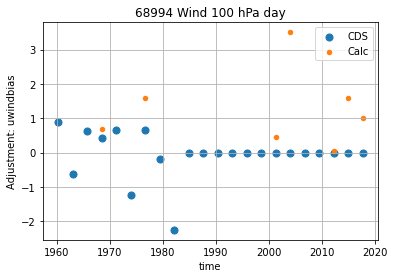

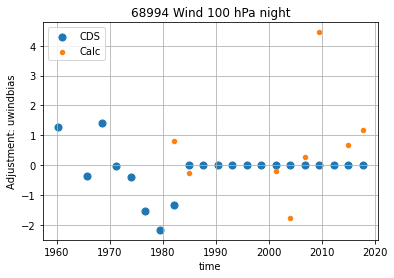

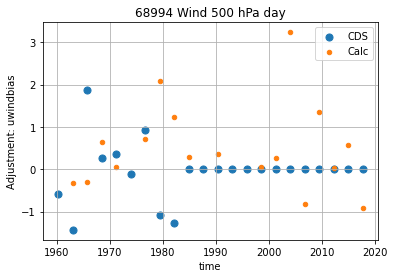

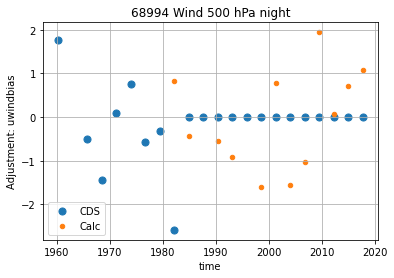

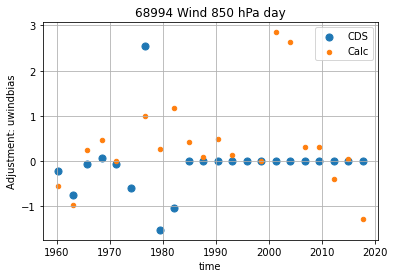

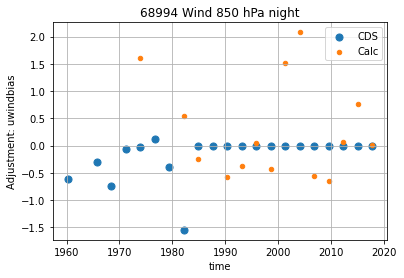

In [4]:
station = '68994'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir068994.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 14.61 MB
Filename: ./Wind_adjustment/068994/feedbackmergedwinddir068994.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 19609)
 - V | datum________________________________________ : : (19609,)
 - V | directionbias________________________________ : : (2, 16, 19609)
 - V | era5_fgdep___________________________________ : : (2, 16, 19609)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 19609)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (19609,)
 - V | uwindb

2021-05-05 14:18:40,022 INFO Welcome to the CDS
2021-05-05 14:18:40,022 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:18:40,189 INFO Request is completed
2021-05-05 14:18:40,190 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620217012.1412168-21886-4-713304bf-65de-4392-82d6-28973a383c8b.zip to download.zip (10.6M)
2021-05-05 14:18:40,931 INFO Download rate 14.3M/s  
2021-05-05 14:18:41,052 INFO Reading Profile on slice(None, None, None)


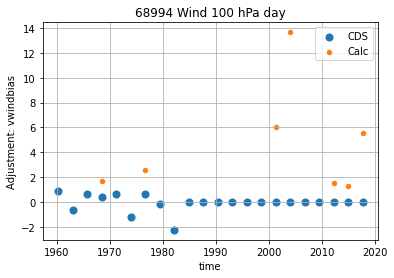

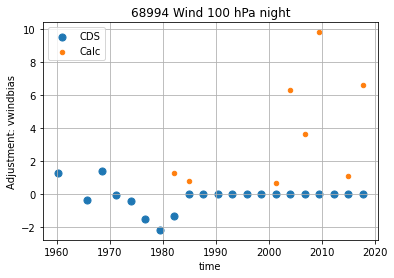

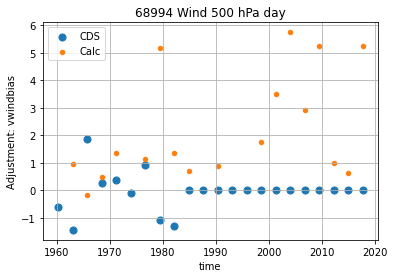

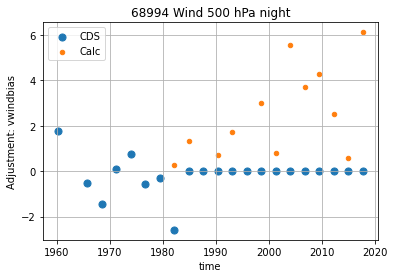

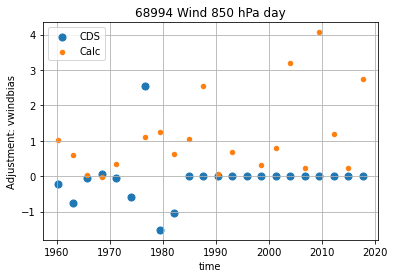

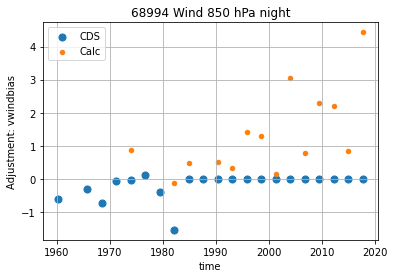

In [5]:
station = '68994'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir068994.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 14.61 MB
Filename: ./Wind_adjustment/068994/feedbackmergedwinddir068994.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 19609)
 - V | datum________________________________________ : : (19609,)
 - V | directionbias________________________________ : : (2, 16, 19609)
 - V | era5_fgdep___________________________________ : : (2, 16, 19609)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 19609)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (19609,)
 - V | uwindb

2021-05-05 14:18:52,031 INFO Welcome to the CDS
2021-05-05 14:18:52,032 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:18:52,708 INFO Request is completed
2021-05-05 14:18:52,709 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620217027.1658025-7372-9-46ff8c38-f4cd-4ad6-ad00-b90a2cd762ce.zip to download.zip (9.7M)
2021-05-05 14:18:53,692 INFO Download rate 9.9M/s   
2021-05-05 14:18:53,762 INFO Reading Profile on slice(None, None, None)


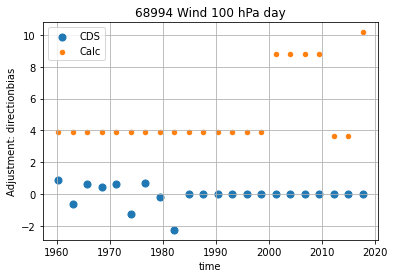

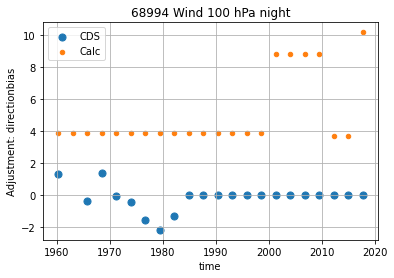

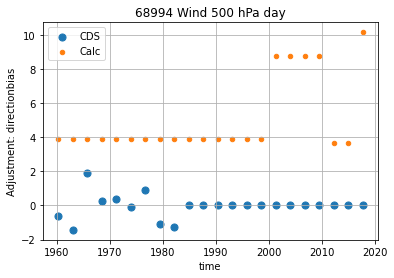

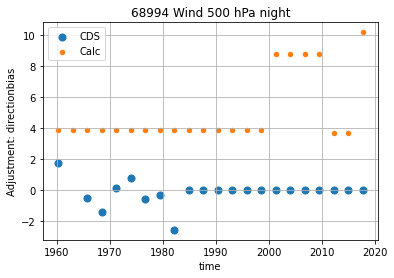

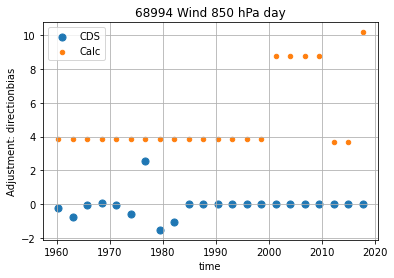

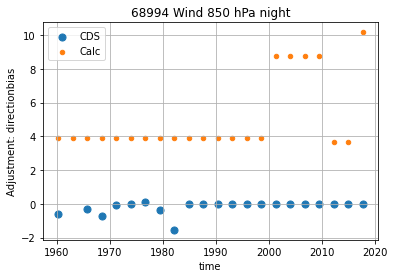

In [6]:
station = '68994'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir035229.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 17.55 MB
Filename: ./Wind_adjustment/035229/feedbackmergedwinddir035229.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 23562)
 - V | datum________________________________________ : : (23562,)
 - V | directionbias________________________________ : : (2, 16, 23562)
 - V | era5_fgdep___________________________________ : : (2, 16, 23562)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 23562)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (23562,)
 - V | uwindb

2021-05-05 14:19:02,725 INFO Welcome to the CDS
2021-05-05 14:19:02,726 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:19:02,909 INFO Request is completed
2021-05-05 14:19:02,911 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620217047.2204833-21492-18-e231c371-1fc0-42de-b442-964752356a0f.zip to download.zip (10.7M)
2021-05-05 14:19:03,973 INFO Download rate 10.1M/s  
2021-05-05 14:19:04,072 INFO Reading Profile on slice(None, None, None)


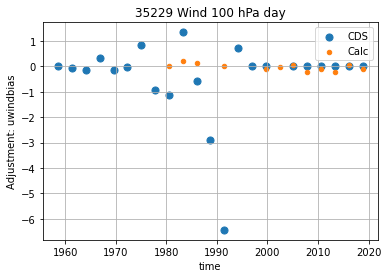

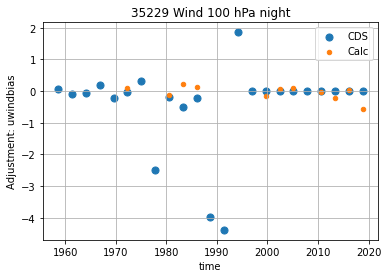

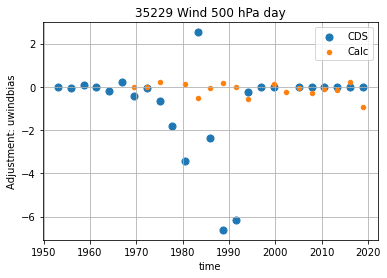

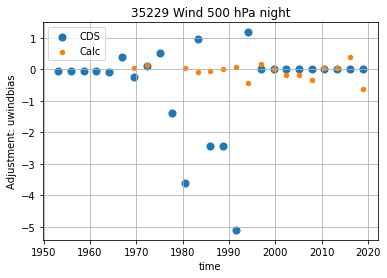

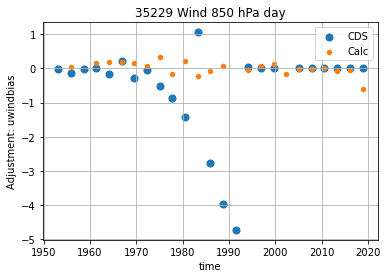

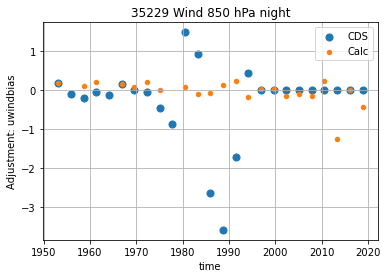

In [7]:
station = '35229'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir035229.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 17.55 MB
Filename: ./Wind_adjustment/035229/feedbackmergedwinddir035229.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 23562)
 - V | datum________________________________________ : : (23562,)
 - V | directionbias________________________________ : : (2, 16, 23562)
 - V | era5_fgdep___________________________________ : : (2, 16, 23562)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 23562)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (23562,)
 - V | uwindb

2021-05-05 14:19:17,670 INFO Welcome to the CDS
2021-05-05 14:19:17,671 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:19:17,849 INFO Request is completed
2021-05-05 14:19:17,850 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620217068.0501404-21529-17-2ec99c63-5a08-4337-8a03-2c04ed3b1607.zip to download.zip (10.7M)
2021-05-05 14:19:19,043 INFO Download rate 9M/s     
2021-05-05 14:19:19,118 INFO Reading Profile on slice(None, None, None)


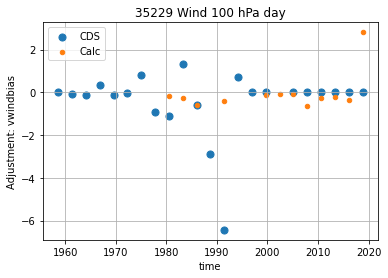

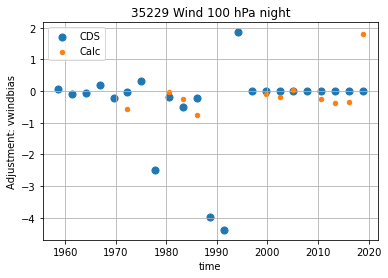

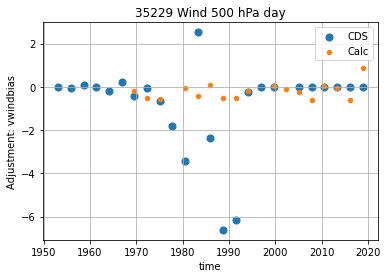

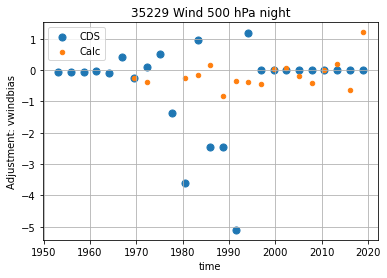

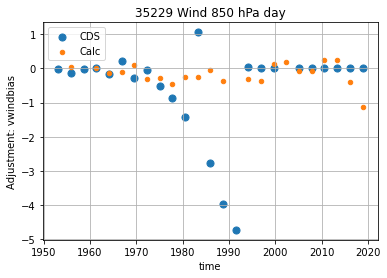

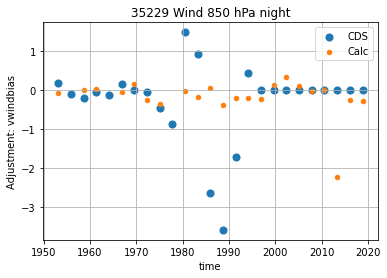

In [8]:
station = '35229'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir035229.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 17.55 MB
Filename: ./Wind_adjustment/035229/feedbackmergedwinddir035229.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 23562)
 - V | datum________________________________________ : : (23562,)
 - V | directionbias________________________________ : : (2, 16, 23562)
 - V | era5_fgdep___________________________________ : : (2, 16, 23562)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 23562)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (23562,)
 - V | uwindb

2021-05-05 14:19:32,127 INFO Welcome to the CDS
2021-05-05 14:19:32,128 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:19:32,303 INFO Request is completed
2021-05-05 14:19:32,304 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620217087.5164037-23355-25-5108bbfa-afda-49e9-94cb-3c4e3940d8d6.zip to download.zip (9.3M)
2021-05-05 14:19:33,066 INFO Download rate 12.1M/s  
2021-05-05 14:19:33,128 INFO Reading Profile on slice(None, None, None)


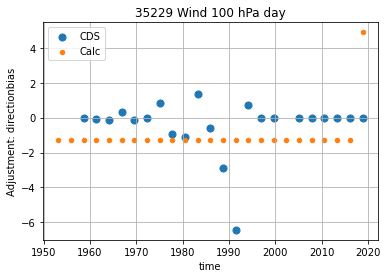

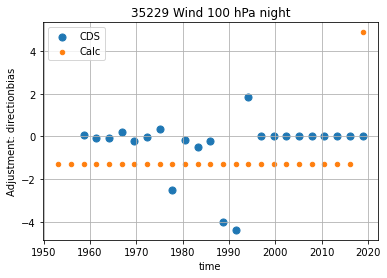

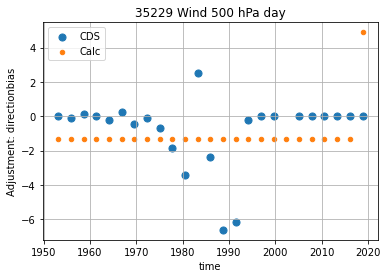

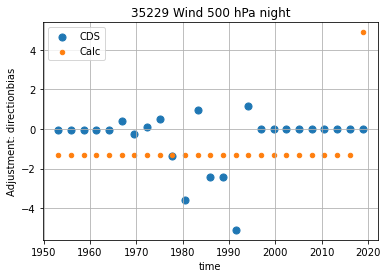

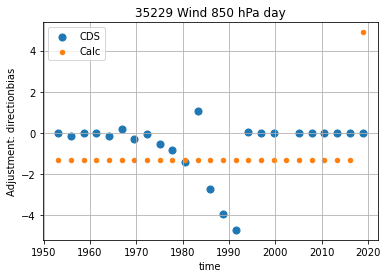

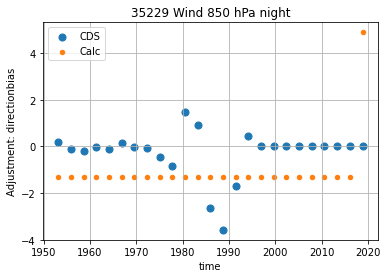

In [9]:
station = '35229'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir070219.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 20.94 MB
Filename: ./Wind_adjustment/070219/feedbackmergedwinddir070219.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 28125)
 - V | datum________________________________________ : : (28125,)
 - V | directionbias________________________________ : : (2, 16, 28125)
 - V | era5_fgdep___________________________________ : : (2, 16, 28125)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 28125)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (28125,)
 - V | uwindb

2021-05-05 14:19:45,488 INFO Welcome to the CDS
2021-05-05 14:19:45,489 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:19:45,659 INFO Request is completed
2021-05-05 14:19:45,660 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620217109.950172-25508-19-6ff87d32-6b21-43b3-a04d-2b4b21b66fc0.zip to download.zip (22.7M)
2021-05-05 14:19:47,197 INFO Download rate 14.8M/s  
2021-05-05 14:19:47,542 INFO Reading Profile on slice(None, None, None)


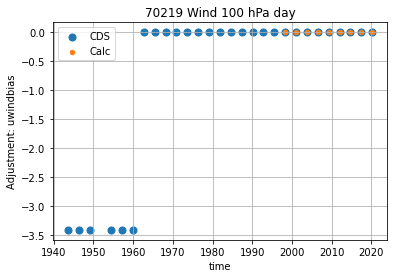

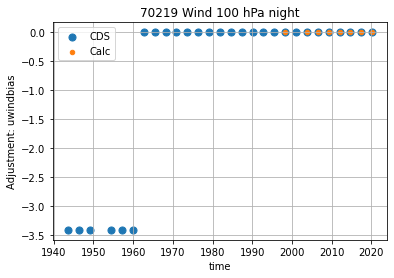

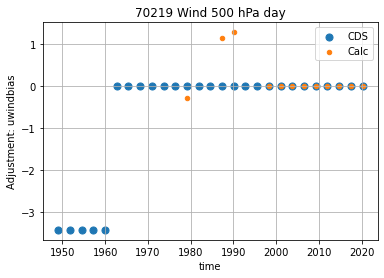

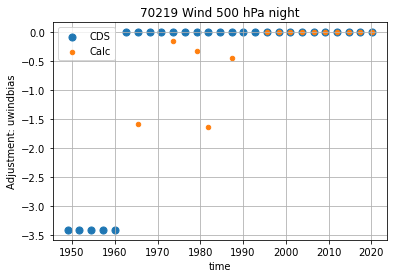

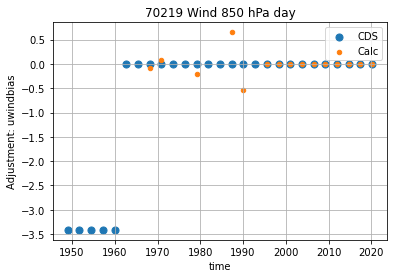

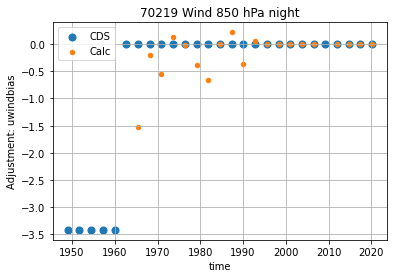

In [10]:
station = '70219'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir070219.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 20.94 MB
Filename: ./Wind_adjustment/070219/feedbackmergedwinddir070219.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 28125)
 - V | datum________________________________________ : : (28125,)
 - V | directionbias________________________________ : : (2, 16, 28125)
 - V | era5_fgdep___________________________________ : : (2, 16, 28125)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 28125)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (28125,)
 - V | uwindb

2021-05-05 14:20:10,048 INFO Welcome to the CDS
2021-05-05 14:20:10,049 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:20:12,735 INFO Request is queued
2021-05-05 14:20:15,310 INFO Request is running
2021-05-05 14:20:21,015 INFO Request is completed
2021-05-05 14:20:21,018 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620217219.1788518-20903-14-2133bbeb-a906-4209-8bf8-bb66f591d669.zip to download.zip (22.7M)
2021-05-05 14:20:23,219 INFO Download rate 10.3M/s  
2021-05-05 14:20:23,339 INFO Reading Profile on slice(None, None, None)


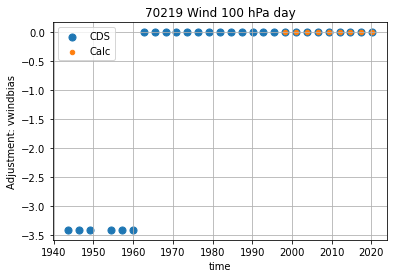

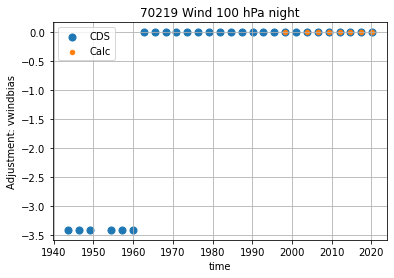

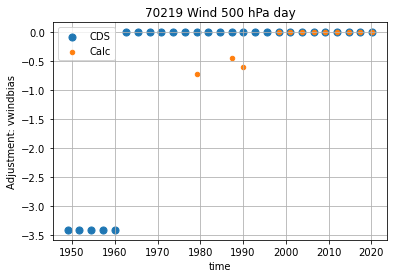

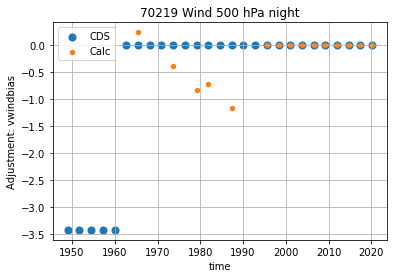

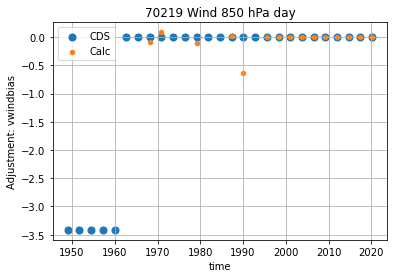

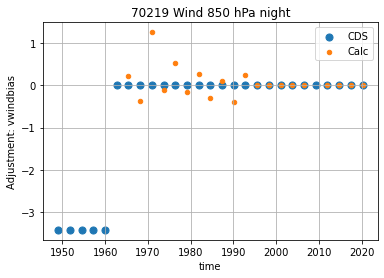

In [11]:
station = '70219'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir070219.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 20.94 MB
Filename: ./Wind_adjustment/070219/feedbackmergedwinddir070219.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 28125)
 - V | datum________________________________________ : : (28125,)
 - V | directionbias________________________________ : : (2, 16, 28125)
 - V | era5_fgdep___________________________________ : : (2, 16, 28125)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 28125)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (28125,)
 - V | uwindb

2021-05-05 14:20:40,544 INFO Welcome to the CDS
2021-05-05 14:20:40,545 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:20:40,726 INFO Request is completed
2021-05-05 14:20:40,727 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620130746.408693-7818-3-dffbac9b-256c-4e83-85c5-09063c1bd783.zip to download.zip (21.9M)
2021-05-05 14:20:42,686 INFO Download rate 11.2M/s  
2021-05-05 14:20:43,049 INFO Reading Profile on slice(None, None, None)


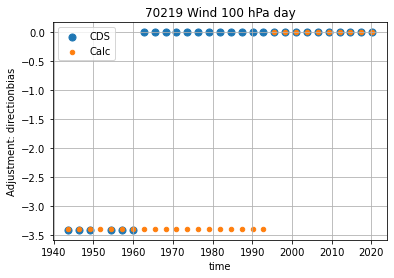

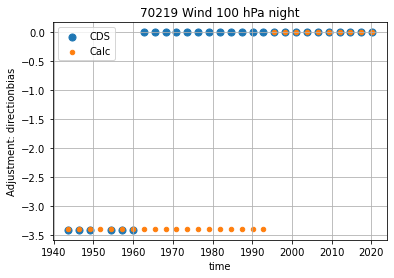

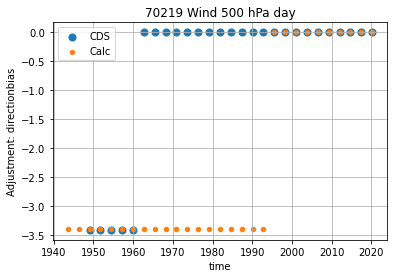

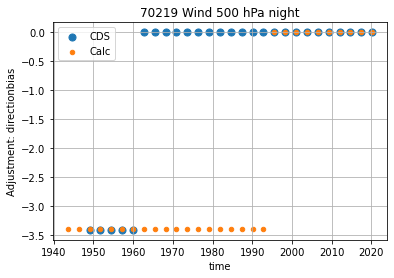

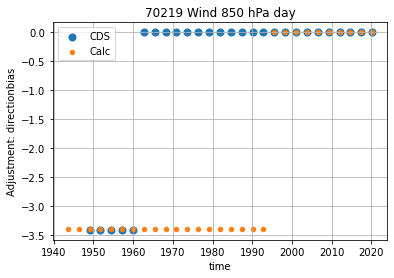

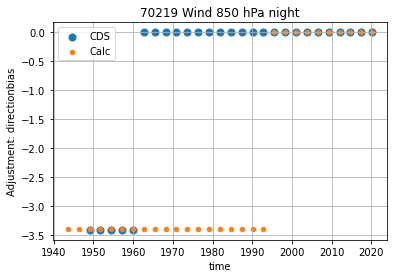

In [12]:
station = '70219'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir010393.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 16.13 MB
Filename: ./Wind_adjustment/010393/feedbackmergedwinddir010393.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 21657)
 - V | datum________________________________________ : : (21657,)
 - V | directionbias________________________________ : : (2, 16, 21657)
 - V | era5_fgdep___________________________________ : : (2, 16, 21657)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 21657)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (21657,)
 - V | uwindb

2021-05-05 14:20:59,015 INFO Welcome to the CDS
2021-05-05 14:20:59,015 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:21:01,681 INFO Request is queued
2021-05-05 14:21:04,249 INFO Request is running
2021-05-05 14:21:22,691 INFO Request is completed
2021-05-05 14:21:22,693 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620217279.4593828-27896-17-dd34d346-4cb7-4849-80e4-4e7a0e77752b.zip to download.zip (32.3M)
2021-05-05 14:21:24,931 INFO Download rate 14.4M/s  
2021-05-05 14:21:25,417 INFO Reading Profile on slice(None, None, None)


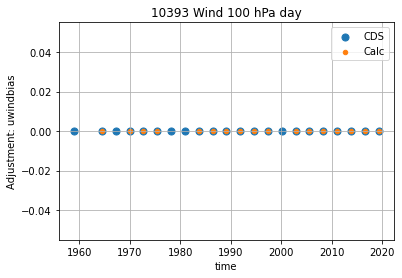

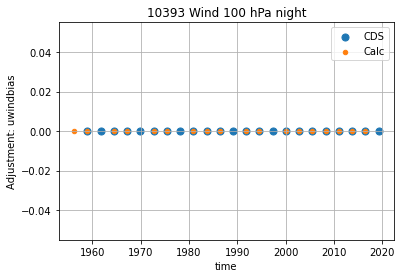

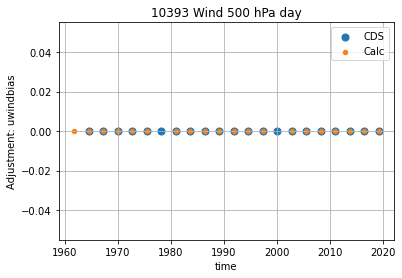

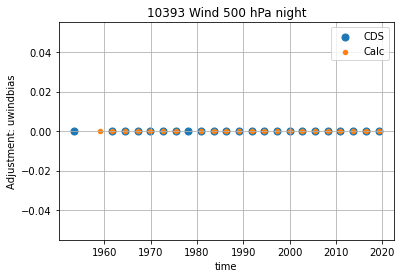

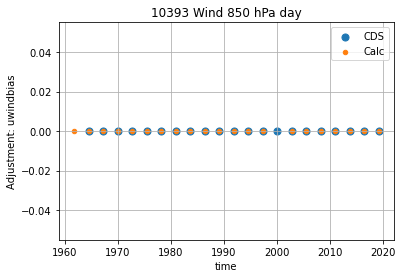

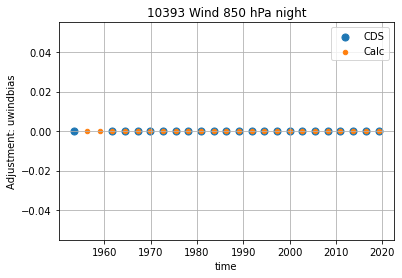

In [13]:
station = '10393'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir010393.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 16.13 MB
Filename: ./Wind_adjustment/010393/feedbackmergedwinddir010393.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 21657)
 - V | datum________________________________________ : : (21657,)
 - V | directionbias________________________________ : : (2, 16, 21657)
 - V | era5_fgdep___________________________________ : : (2, 16, 21657)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 21657)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (21657,)
 - V | uwindb

2021-05-05 14:21:47,362 INFO Welcome to the CDS
2021-05-05 14:21:47,363 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:21:47,536 INFO Request is completed
2021-05-05 14:21:47,538 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620207282.5646477-26606-6-6a1bd567-9646-44a6-b546-9fd42f7caa20.zip to download.zip (32.3M)
2021-05-05 14:21:49,986 INFO Download rate 13.2M/s  
2021-05-05 14:21:50,410 INFO Reading Profile on slice(None, None, None)


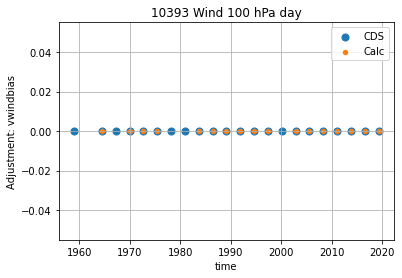

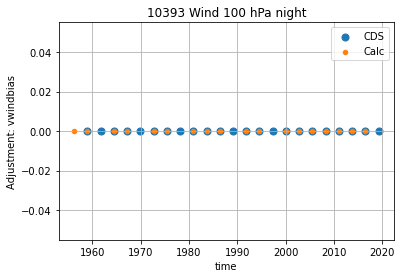

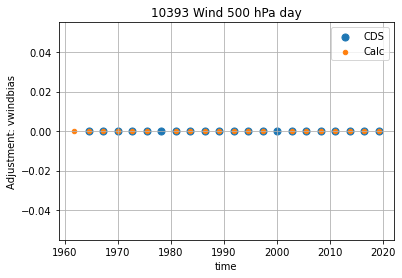

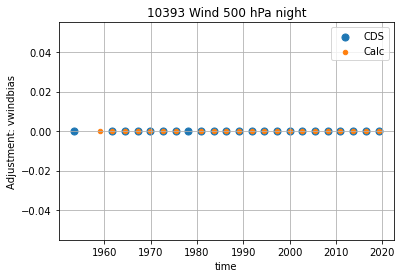

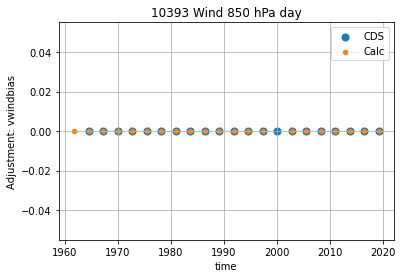

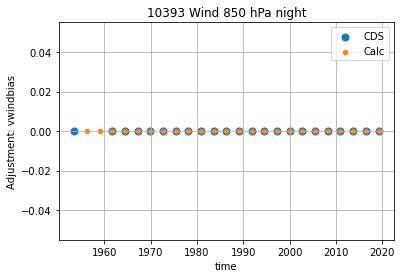

In [14]:
station = '10393'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir010393.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 16.13 MB
Filename: ./Wind_adjustment/010393/feedbackmergedwinddir010393.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 21657)
 - V | datum________________________________________ : : (21657,)
 - V | directionbias________________________________ : : (2, 16, 21657)
 - V | era5_fgdep___________________________________ : : (2, 16, 21657)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 21657)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (21657,)
 - V | uwindb

2021-05-05 14:22:15,992 INFO Welcome to the CDS
2021-05-05 14:22:15,994 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:22:18,689 INFO Request is queued
2021-05-05 14:22:21,268 INFO Request is running
2021-05-05 14:22:39,718 INFO Request is completed
2021-05-05 14:22:39,722 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620217356.0663428-27932-17-a8620096-4270-4615-b017-c18ee714c35a.zip to download.zip (31.1M)
2021-05-05 14:22:41,741 INFO Download rate 15.4M/s  
2021-05-05 14:22:42,105 INFO Reading Profile on slice(None, None, None)


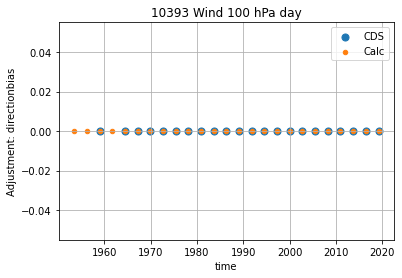

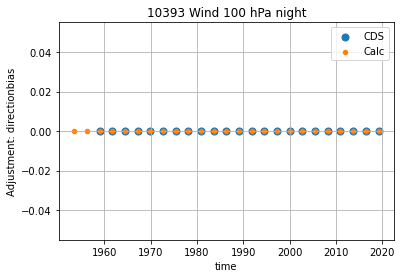

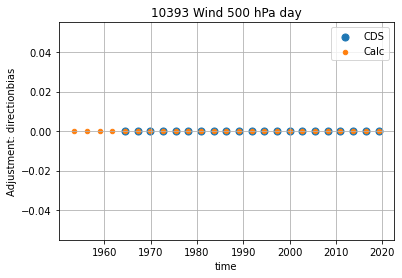

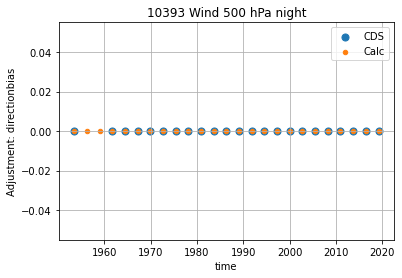

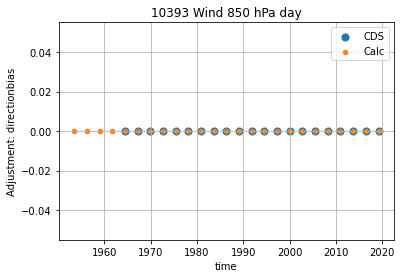

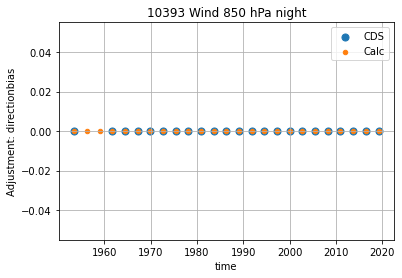

In [15]:
station = '10393'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir011035.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 19.47 MB
Filename: ./Wind_adjustment/011035/feedbackmergedwinddir011035.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 26148)
 - V | datum________________________________________ : : (26148,)
 - V | directionbias________________________________ : : (2, 16, 26148)
 - V | era5_fgdep___________________________________ : : (2, 16, 26148)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 26148)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (26148,)
 - V | uwindb

2021-05-05 14:23:07,662 INFO Welcome to the CDS
2021-05-05 14:23:07,664 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:23:10,349 INFO Request is queued
2021-05-05 14:23:12,967 INFO Request is running
2021-05-05 14:23:23,779 INFO Request is completed
2021-05-05 14:23:23,781 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620217400.4732718-28023-17-3bf6d1a3-acbf-4138-b852-dc6f9c6cffeb.zip to download.zip (35.8M)
2021-05-05 14:23:26,716 INFO Download rate 12.2M/s  
2021-05-05 14:23:27,296 INFO Reading Profile on slice(None, None, None)


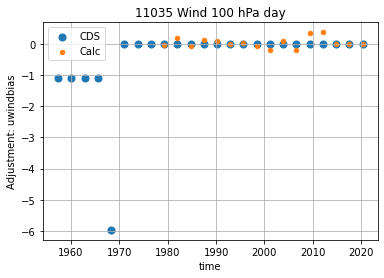

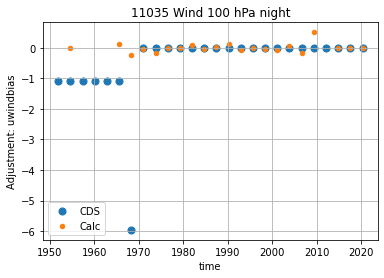

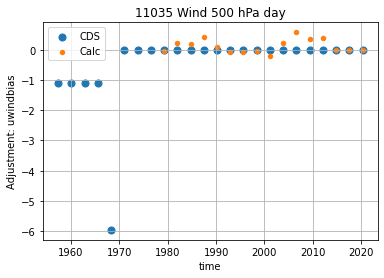

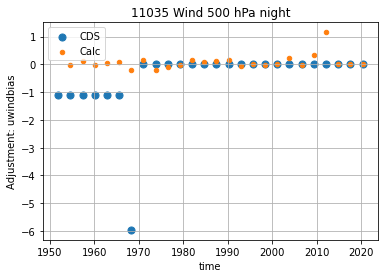

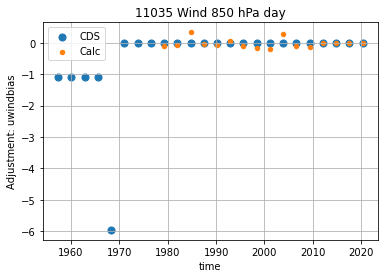

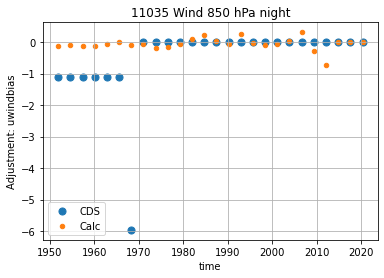

In [16]:
station = '11035'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir011035.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 19.47 MB
Filename: ./Wind_adjustment/011035/feedbackmergedwinddir011035.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 26148)
 - V | datum________________________________________ : : (26148,)
 - V | directionbias________________________________ : : (2, 16, 26148)
 - V | era5_fgdep___________________________________ : : (2, 16, 26148)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 26148)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (26148,)
 - V | uwindb

2021-05-05 14:23:53,037 INFO Welcome to the CDS
2021-05-05 14:23:53,038 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:23:55,710 INFO Request is queued
2021-05-05 14:23:58,290 INFO Request is running
2021-05-05 14:24:03,996 INFO Request is completed
2021-05-05 14:24:03,998 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620217442.2666943-27723-16-009fba8c-757e-4802-a51b-035a98c4d4ac.zip to download.zip (35.8M)
2021-05-05 14:24:06,862 INFO Download rate 12.5M/s  
2021-05-05 14:24:07,372 INFO Reading Profile on slice(None, None, None)


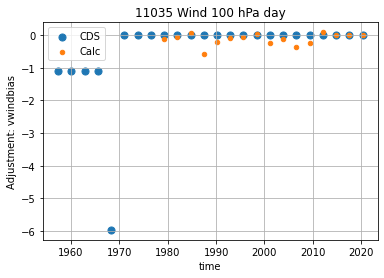

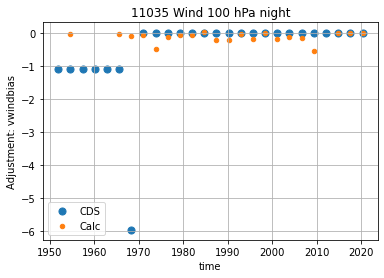

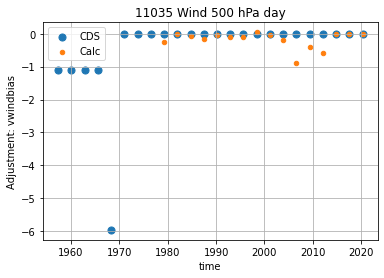

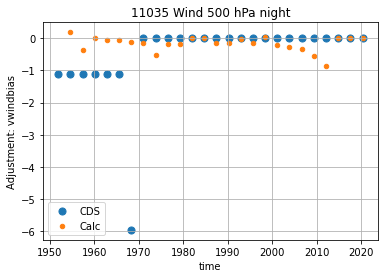

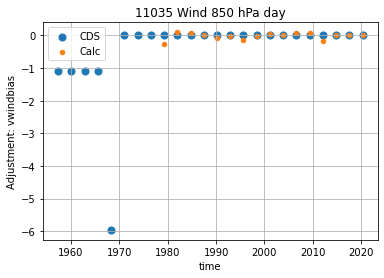

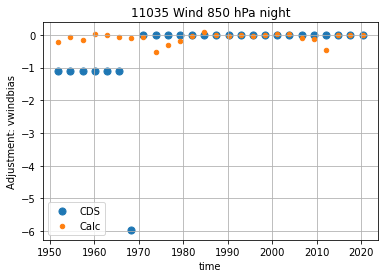

In [17]:
station = '11035'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir011035.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 19.47 MB
Filename: ./Wind_adjustment/011035/feedbackmergedwinddir011035.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 26148)
 - V | datum________________________________________ : : (26148,)
 - V | directionbias________________________________ : : (2, 16, 26148)
 - V | era5_fgdep___________________________________ : : (2, 16, 26148)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 26148)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (26148,)
 - V | uwindb

2021-05-05 14:24:29,322 INFO Welcome to the CDS
2021-05-05 14:24:29,323 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:24:29,491 INFO Request is completed
2021-05-05 14:24:29,493 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620206673.8221123-11993-18-81097d1f-eeb6-4e68-bc5c-88090abff6c7.zip to download.zip (34.5M)
2021-05-05 14:24:33,504 INFO Download rate 8.6M/s   
2021-05-05 14:24:33,991 INFO Reading Profile on slice(None, None, None)


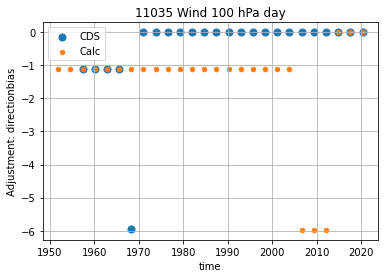

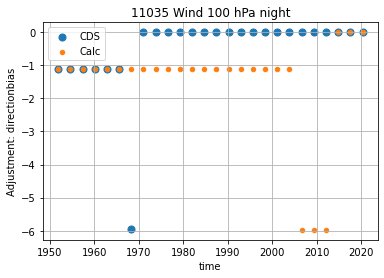

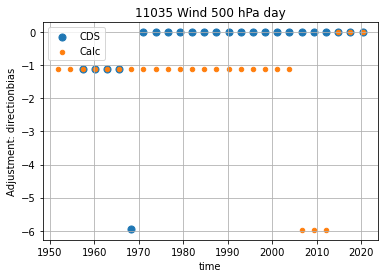

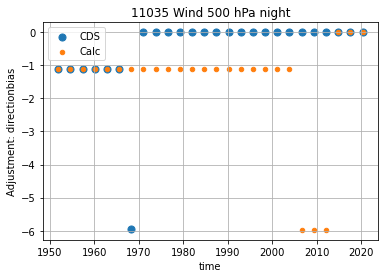

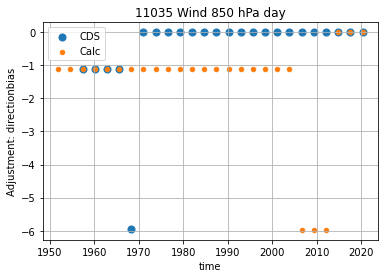

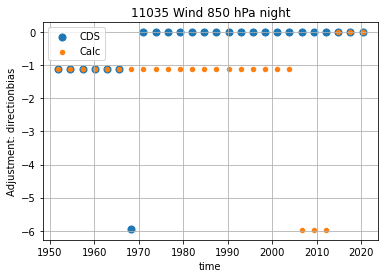

In [18]:
station = '11035'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir091413.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 18.85 MB
Filename: ./Wind_adjustment/091413/feedbackmergedwinddir091413.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 25304)
 - V | datum________________________________________ : : (25304,)
 - V | directionbias________________________________ : : (2, 16, 25304)
 - V | era5_fgdep___________________________________ : : (2, 16, 25304)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 25304)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (25304,)
 - V | uwindb

2021-05-05 14:24:59,266 INFO Welcome to the CDS
2021-05-05 14:24:59,267 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:24:59,464 INFO Request is completed
2021-05-05 14:24:59,466 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620207457.4331403-28127-5-2e878161-f7e1-495b-8a16-4849157bc041.zip to download.zip (27.5M)
2021-05-05 14:25:02,184 INFO Download rate 10.1M/s  
2021-05-05 14:25:02,713 INFO Reading Profile on slice(None, None, None)


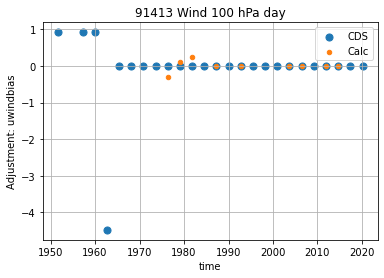

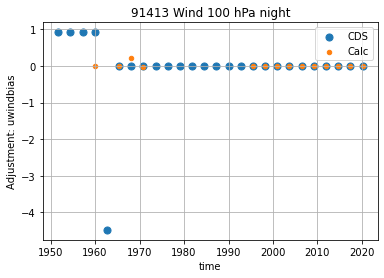

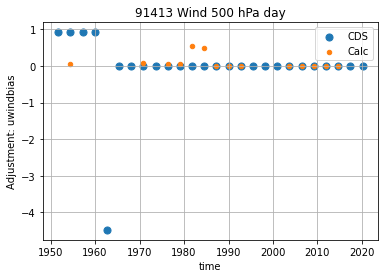

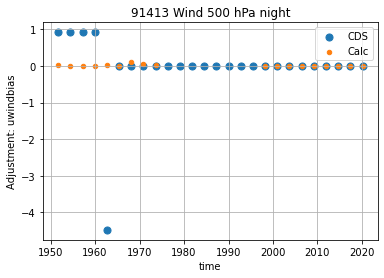

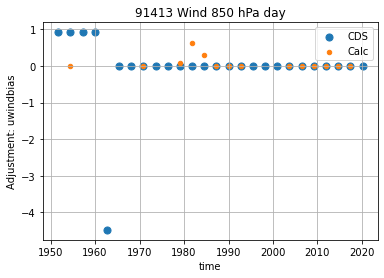

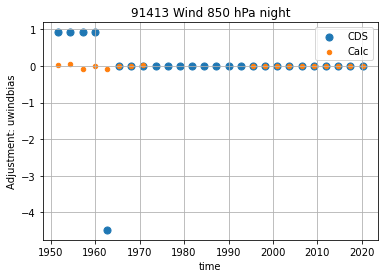

In [19]:
station = '91413'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir091413.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 18.85 MB
Filename: ./Wind_adjustment/091413/feedbackmergedwinddir091413.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 25304)
 - V | datum________________________________________ : : (25304,)
 - V | directionbias________________________________ : : (2, 16, 25304)
 - V | era5_fgdep___________________________________ : : (2, 16, 25304)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 25304)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (25304,)
 - V | uwindb

2021-05-05 14:25:18,182 INFO Welcome to the CDS
2021-05-05 14:25:18,182 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:25:20,857 INFO Request is queued
2021-05-05 14:25:23,436 INFO Request is running
2021-05-05 14:25:25,729 INFO Request is completed
2021-05-05 14:25:25,731 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620217525.1246147-21513-18-50f78705-3147-4e6d-82ed-379e26714762.zip to download.zip (27.6M)
2021-05-05 14:25:28,523 INFO Download rate 9.9M/s   
2021-05-05 14:25:28,845 INFO Reading Profile on slice(None, None, None)


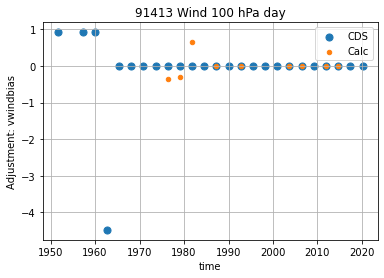

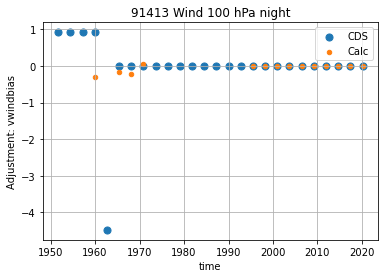

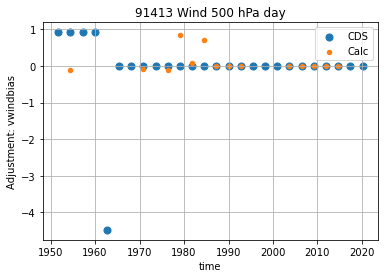

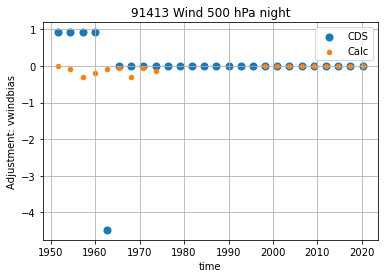

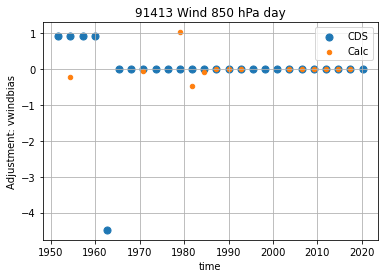

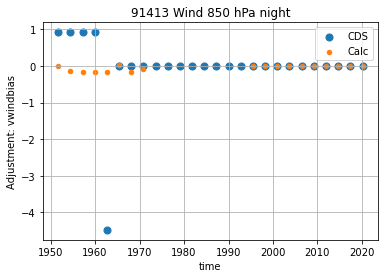

In [20]:
station = '91413'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir091413.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 18.85 MB
Filename: ./Wind_adjustment/091413/feedbackmergedwinddir091413.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 25304)
 - V | datum________________________________________ : : (25304,)
 - V | directionbias________________________________ : : (2, 16, 25304)
 - V | era5_fgdep___________________________________ : : (2, 16, 25304)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 25304)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (25304,)
 - V | uwindb

[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 14:25:44,575 INFO Welcome to the CDS
2021-05-05 14:25:44,576 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2021-05-05 14:25:44,768 INFO Request is completed
2021-05-05 14:25:44,770 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620206842.4680758-12353-18-366f06f6-b322-4646-82cd-8f74e9fc46a2.zip to download.zip (27M)
2021-05-05 14:25:46,929 INFO Download rate 12.5M/s  
2021-05-05 14:25:47,189 INFO Reading Profile on slice(None, None, None)


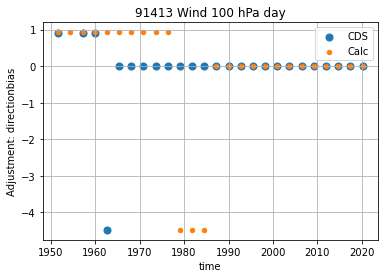

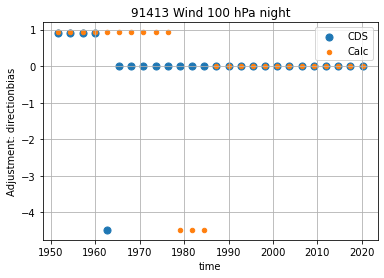

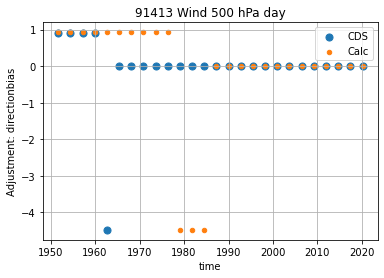

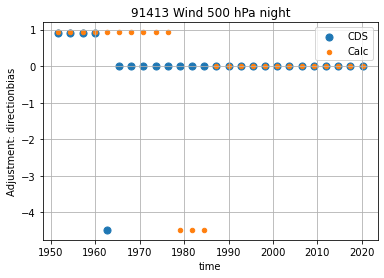

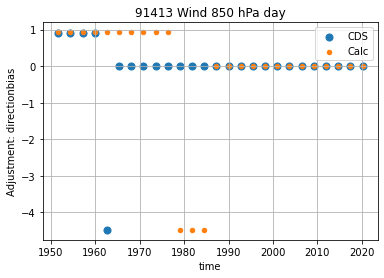

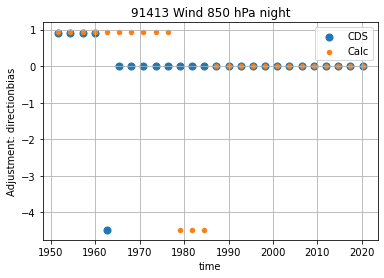

In [21]:
station = '91413'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)